In [15]:
# necessary imports
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from io import StringIO

### Load Data

In [16]:
df = pd.read_csv(os.path.join("clean_data", "final_data.csv"))

## Descriptive Statistics

In [19]:
# number of data points
df.shape[0]

193068

In [47]:
df.describe(include="all")

,timestamp,name,category,brightness,at_home,stress,valence,arousal,attention,pcode
count,193068,193068,193068,191135,193068,190453.000000,190453.000000,190453.000000,190453.000000,190453
unique,193049,268,10,3,2,NaN,NaN,NaN,NaN,77
top,2019-05-16 11:09:33.834000+09:00,Facebook,SOCIAL,LOW,False,NaN,NaN,NaN,NaN,P56
freq,2,47637,109561,178294,154641,NaN,NaN,NaN,NaN,11036
mean,NaN,NaN,NaN,NaN,NaN,0.312823,0.550141,0.366663,0.472095,NaN
std,NaN,NaN,NaN,NaN,NaN,0.463644,0.497481,0.481895,0.499222,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,0.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN


### Distributions

In [37]:
def plot_distribution_of_values(col):
    plt.figure(figsize=(6, 4))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Value Counts of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show();

#### category

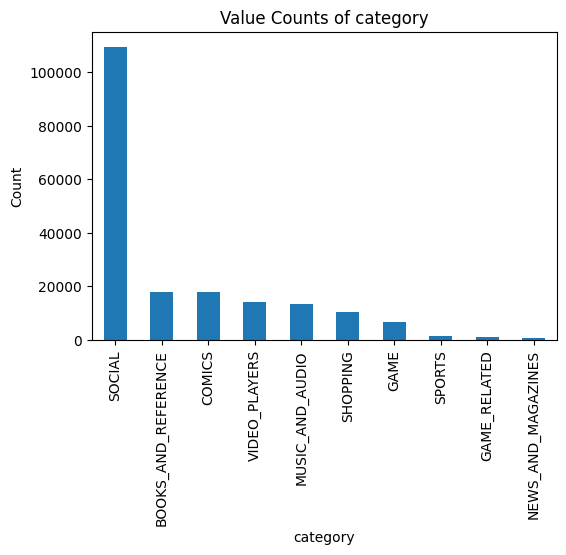

In [38]:
plot_distribution_of_values("category")

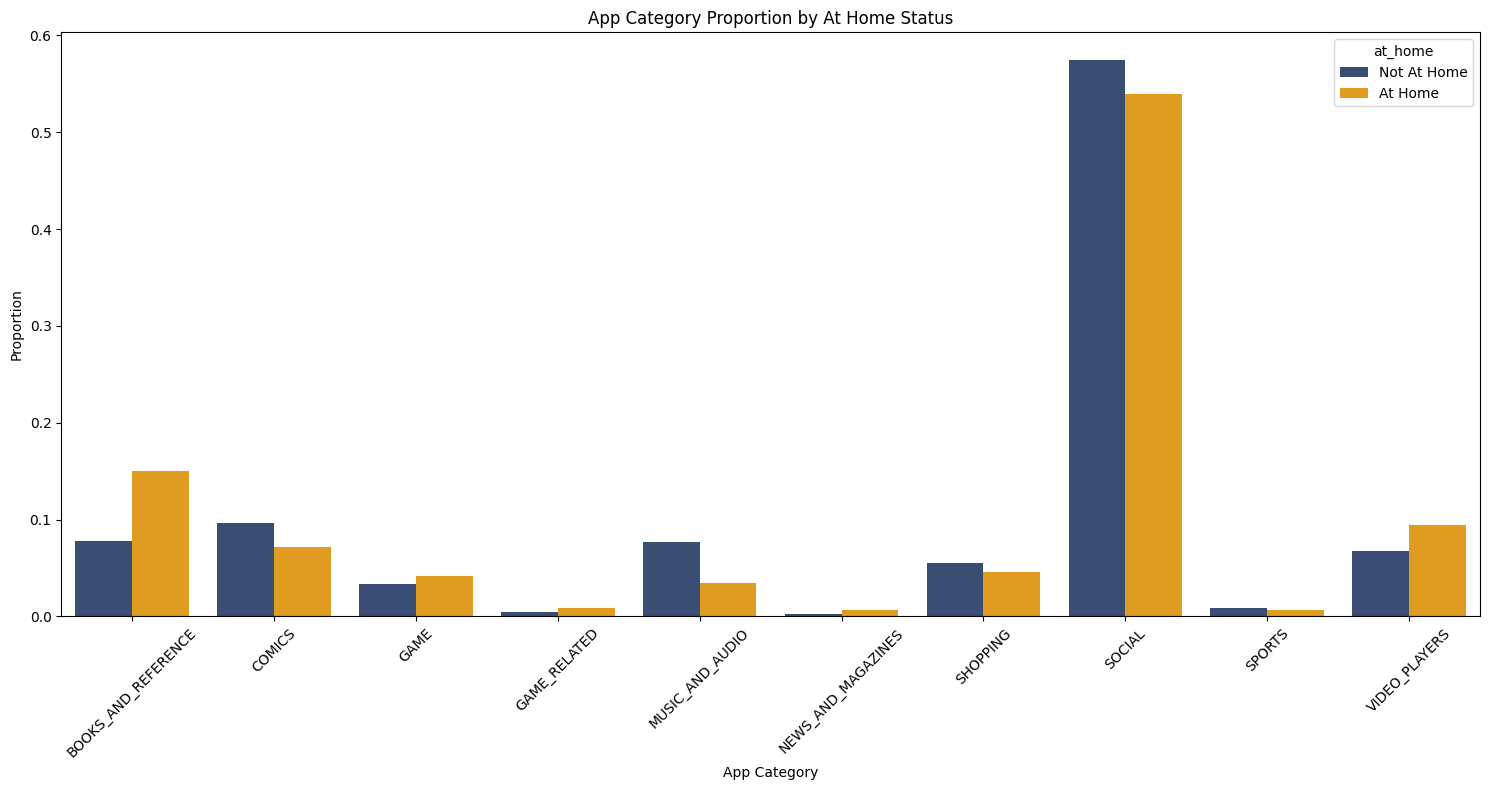

In [46]:
# Calculate the distributions
at_home_dist = df[df["at_home"]]["category"].value_counts() / df[df["at_home"]].shape[0]
not_at_home_dist = df[~df["at_home"]]["category"].value_counts() / df[~df["at_home"]].shape[0]

# Create a DataFrame for plotting
dist_df = pd.DataFrame({
    'category': at_home_dist.index.tolist() + not_at_home_dist.index.tolist(),
    'proportion': at_home_dist.tolist() + not_at_home_dist.tolist(),
    'at_home': ['At Home'] * len(at_home_dist) + ['Not At Home'] * len(not_at_home_dist)
}).sort_values(by=["proportion"], ascending=False)

# Sort the DataFrame by app_category
dist_df = dist_df.sort_values(by=['category', 'at_home'], ascending=[True, False])

# Plot the data
plt.figure(figsize=(15, 8))
sns.barplot(x='category', y='proportion', hue='at_home', data=dist_df, palette=['#2f4b7c', '#ffa600'])
plt.xlabel('App Category')
plt.ylabel('Proportion')
plt.title('App Category Proportion by At Home Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### brightness and at_home

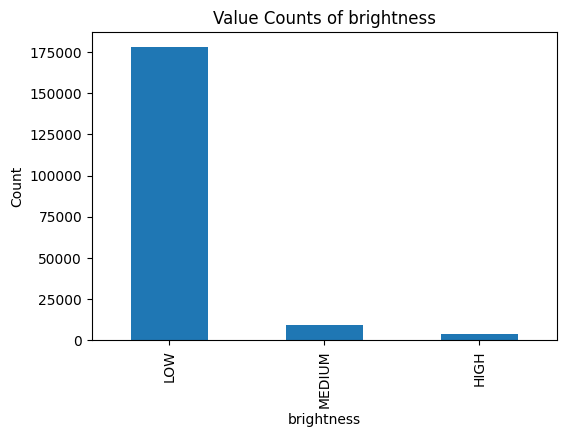

In [39]:
plot_distribution_of_values("brightness")

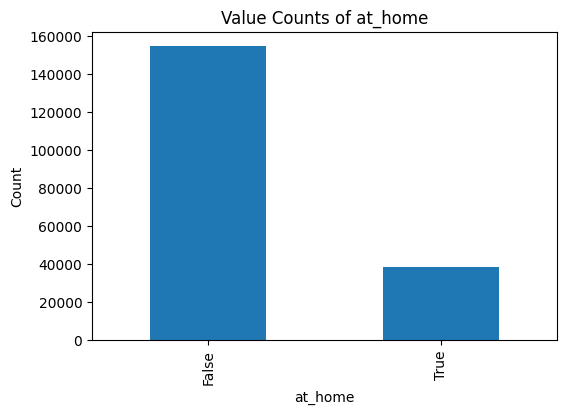

In [40]:
plot_distribution_of_values("at_home")

#### stress, valence, arousal and attention

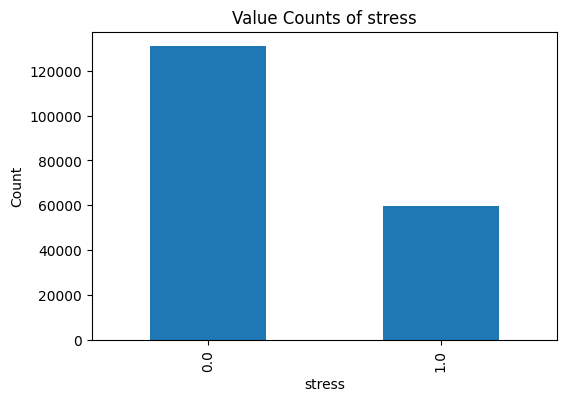

In [41]:
plot_distribution_of_values("stress")

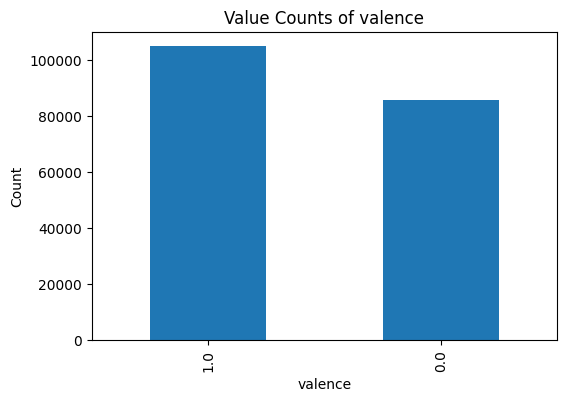

In [42]:
plot_distribution_of_values("valence")

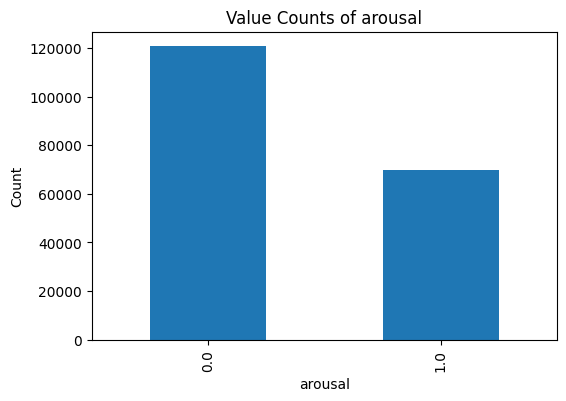

In [43]:
plot_distribution_of_values("arousal")

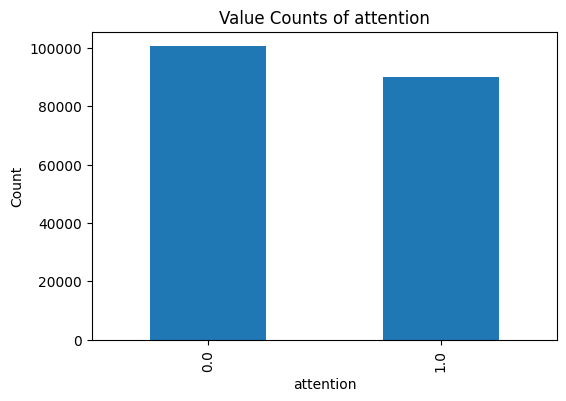

In [44]:
plot_distribution_of_values("attention")

In [9]:
df.describe(include="all")

,timestamp,name,category,brightness,at_home,stress,valence,arousal,attention,pcode
count,191984,191984,191984,190051,191984,189369.000000,189369.000000,189369.00000,189369.000000,189369
unique,191965,260,9,3,2,NaN,NaN,NaN,NaN,77
top,2019-05-21 22:53:44.760000+09:00,Facebook,SOCIAL,LOW,False,NaN,NaN,NaN,NaN,P56
freq,2,47637,109561,177275,153905,NaN,NaN,NaN,NaN,11030
mean,NaN,NaN,NaN,NaN,NaN,0.312765,0.549520,0.36788,0.472231,NaN
std,NaN,NaN,NaN,NaN,NaN,0.463621,0.497543,0.48223,0.499230,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.00000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.00000,0.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.00000,0.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.00000,1.000000,NaN


## Logisitc Regressions with Fixed Effects

- Main Effects: 
    - The models evaluates how app category, being at home and brightness levels influence whether people are stressed, feeling good (valence), attentive and aroused.

- Interaction Effects: 
    - They also evaluate whether the impact of using certain app categories on stress, valence, arousal, attention is different when the participant is at home versus elsewhere, or based on brightness levels.

- Individual Differences: 
    - The model controls for unique characteristics of each participant to get more accurate results.
    
Logistic regression is chosen because it is well-suited for modeling binary outcomes, such as whether a person is stressed (yes/no), feeling good (yes/no), attentive (yes/no), or aroused (yes/no). By using logistic regression, we can estimate the probability of these outcomes based on the predictors (app category, location, brightness) and their interactions. This method allows us to understand the relationship between the predictors and the binary outcomes while accounting for individual differences through fixed effects.

In [89]:
def generate_model(dv):
    formula = f"{dv} ~ C(category) * at_home + C(pcode)"
    return smf.logit(formula=formula, data=df).fit()

def get_model_results(model):
    html_string = model.summary().tables[1].as_html() # Extract the HTML from the model summary
    html_io = StringIO(html_string) # Use StringIO to wrap the HTML string
    df = pd.read_html(html_io, header=0)[0] # Read the HTML into a DataFrame
    df.columns = ["predictor"] + df.columns[1:].to_list() # Rename column
    return df[~df["predictor"].str.contains("pcode")]

def plot_forest(results_df):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.errorbar(results_df["coef"], results_df["predictor"], xerr=1.96*results_df["std err"], fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
    # Add vertical line at zero
    ax.axvline(x=0, linestyle='--', color='red')
    # Add labels and title
    ax.set_xlabel('Coefficient')
    ax.set_ylabel('Predictor')
    ax.set_title('Forest Plot of Coefficient Estimates')
    # Show plot
    plt.show()

In [ ]:
df = stress_df[stress_df["P>|z|"] < .05]
# Plot
fig, ax = plt.subplots(figsize=(10, 8))

ax.errorbar(df["coef"], df["Unnamed: 0"], xerr=1.96*df["std err"], fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)

# Add vertical line at zero
ax.axvline(x=0, linestyle='--', color='red')

# Add labels and title
ax.set_xlabel('Coefficient')
ax.set_ylabel('Variable')
ax.set_title('Forest Plot of Coefficient Estimates')

# Show plot
plt.show()

### Stress

In [76]:
stress_model = generate_model("stress")
stress_results = get_model_results(stress_model)

Optimization terminated successfully.
         Current function value: 0.499745
         Iterations 7


In [77]:
# select only statistacally significant effects
stress_results[stress_results["P>|z|"] < .05]

,predictor,coef,std err,z,P>|z|,[0.025,0.975]
0,Intercept,-2.0686,0.233,-8.863,0.000,-2.526,-1.611
3,C(category)[T.GAME_RELATED],1.1255,0.096,11.721,0.000,0.937,1.314
4,C(category)[T.MUSIC_AND_AUDIO],0.4531,0.034,13.521,0.000,0.387,0.519
5,C(category)[T.NEWS_AND_MAGAZINES],1.0969,0.127,8.611,0.000,0.847,1.347
7,C(category)[T.SOCIAL],0.2101,0.027,7.642,0.000,0.156,0.264
8,C(category)[T.SPORTS],0.3975,0.078,5.121,0.000,0.245,0.550
9,C(category)[T.VIDEO_PLAYERS],0.3184,0.036,8.768,0.000,0.247,0.390
10,at_home[T.True],0.2793,0.043,6.528,0.000,0.195,0.363
89,C(category)[T.GAME_RELATED]:at_home[T.True],-1.3528,0.158,-8.542,0.000,-1.663,-1.042
90,C(category)[T.MUSIC_AND_AUDIO]:at_home[T.True],-1.0072,0.083,-12.128,0.000,-1.170,-0.844


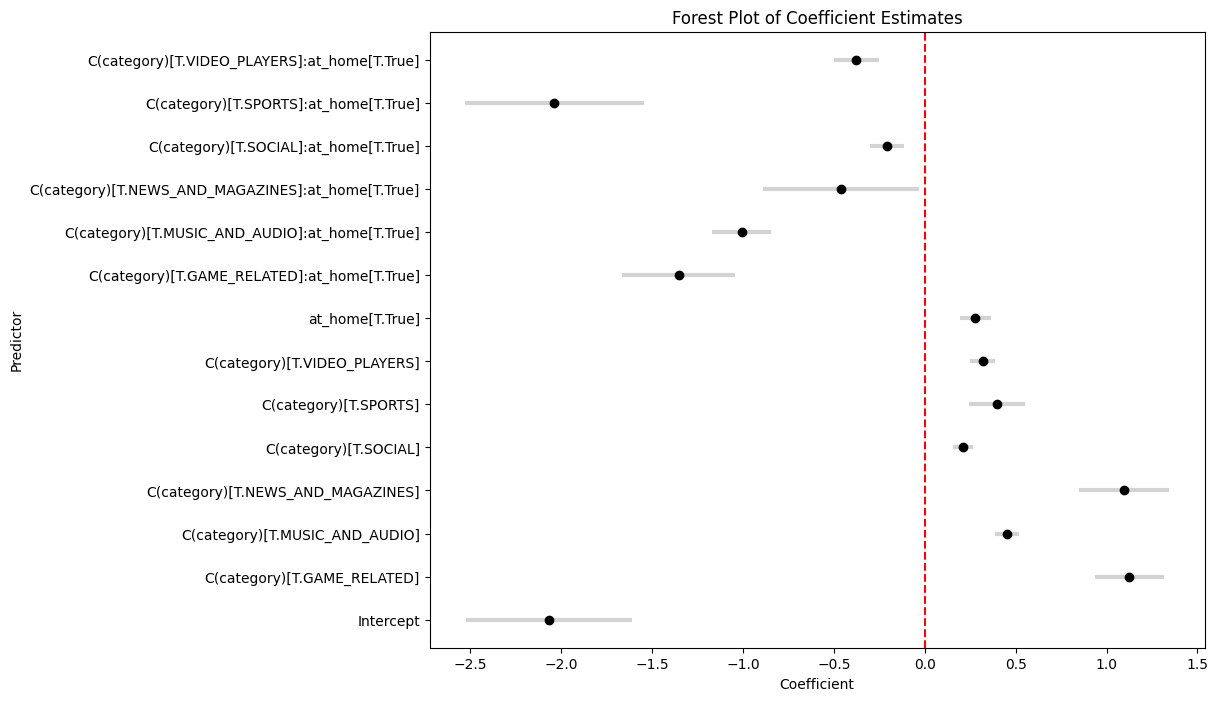

In [90]:
plot_forest(stress_results[stress_results["P>|z|"] < .05])

### Valence

In [78]:
valence_model = generate_model("valence")
valence_results = get_model_results(valence_model)

         Current function value: 0.534613
         Iterations: 35


/Users/mauro/.pyenv/versions/3.10.6/envs/sandbox/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [79]:
# select only statistacally significant effects
valence_results[valence_results["P>|z|"] < .05]

,predictor,coef,std err,z,P>|z|,[0.025,0.975]
0,Intercept,1.8564,0.243,7.637,0.000,1.380,2.333
1,C(category)[T.COMICS],0.0979,0.036,2.729,0.006,0.028,0.168
3,C(category)[T.GAME_RELATED],-0.4108,0.088,-4.649,0.000,-0.584,-0.238
4,C(category)[T.MUSIC_AND_AUDIO],-0.1291,0.038,-3.429,0.001,-0.203,-0.055
5,C(category)[T.NEWS_AND_MAGAZINES],-0.4251,0.148,-2.864,0.004,-0.716,-0.134
6,C(category)[T.SHOPPING],0.0897,0.043,2.085,0.037,0.005,0.174
7,C(category)[T.SOCIAL],-0.1234,0.031,-4.004,0.000,-0.184,-0.063
8,C(category)[T.SPORTS],-0.5696,0.081,-7.029,0.000,-0.728,-0.411
10,at_home[T.True],-0.1817,0.043,-4.230,0.000,-0.266,-0.098
89,C(category)[T.GAME_RELATED]:at_home[T.True],1.4159,0.173,8.173,0.000,1.076,1.755


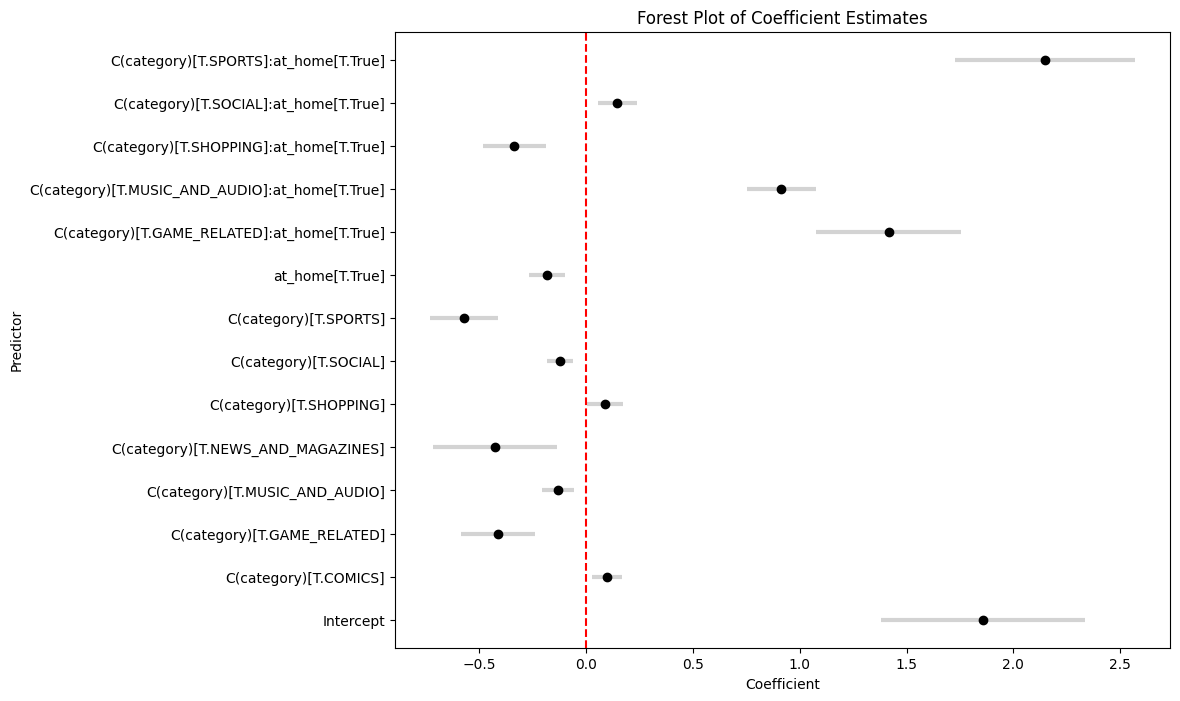

In [91]:
plot_forest(valence_results[valence_results["P>|z|"] < .05])

### Arousal

In [80]:
arousal_model = generate_model("arousal")
arousal_results = get_model_results(arousal_model)

Optimization terminated successfully.
         Current function value: 0.525153
         Iterations 9


In [81]:
# select only statistacally significant effects
arousal_results[arousal_results["P>|z|"] < .05]

,predictor,coef,std err,z,P>|z|,[0.025,0.975]
0,Intercept,0.5020,0.174,2.885,0.004,0.161,0.843
1,C(category)[T.COMICS],0.2638,0.034,7.763,0.000,0.197,0.330
2,C(category)[T.GAME],0.1753,0.041,4.314,0.000,0.096,0.255
3,C(category)[T.GAME_RELATED],-0.3792,0.126,-3.016,0.003,-0.626,-0.133
4,C(category)[T.MUSIC_AND_AUDIO],-0.2440,0.035,-6.932,0.000,-0.313,-0.175
5,C(category)[T.NEWS_AND_MAGAZINES],-0.2897,0.134,-2.169,0.030,-0.552,-0.028
6,C(category)[T.SHOPPING],-0.4967,0.042,-11.964,0.000,-0.578,-0.415
8,C(category)[T.SPORTS],-0.3029,0.081,-3.752,0.000,-0.461,-0.145
9,C(category)[T.VIDEO_PLAYERS],0.1193,0.037,3.248,0.001,0.047,0.191
10,at_home[T.True],-0.2281,0.047,-4.861,0.000,-0.320,-0.136


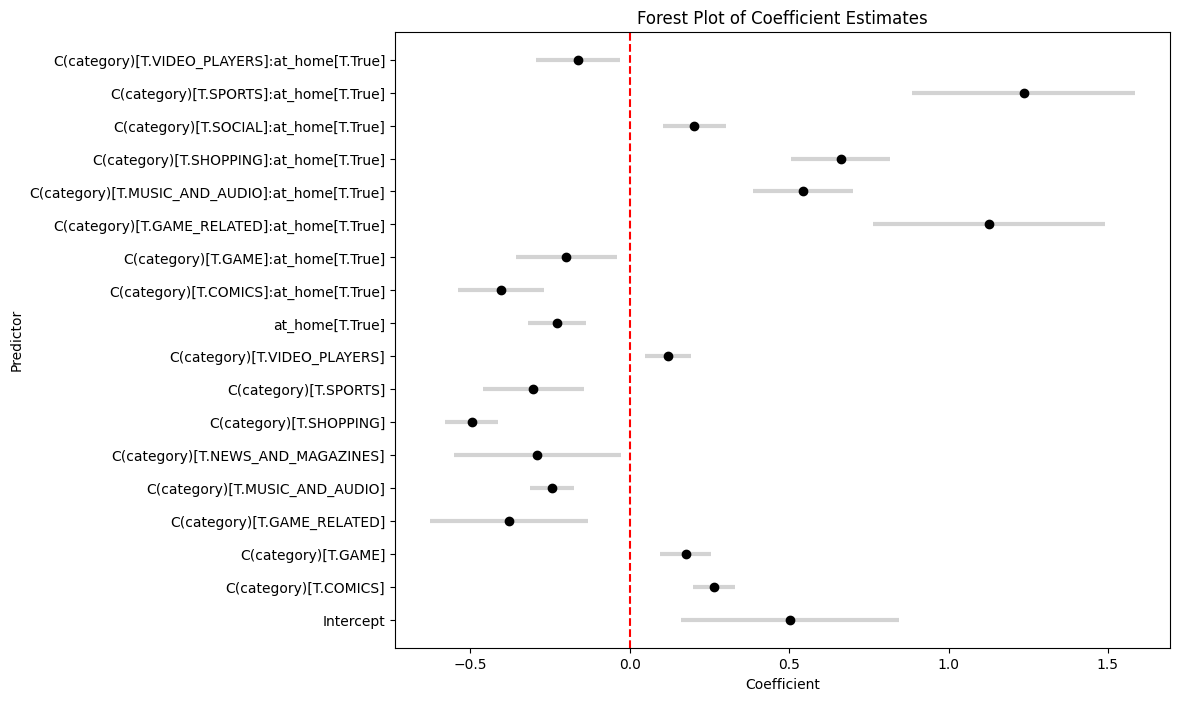

In [92]:
plot_forest(arousal_results[arousal_results["P>|z|"] < .05])

### Attention

In [82]:
attention_model = generate_model("attention")
attention_results = get_model_results(attention_model)

Optimization terminated successfully.
         Current function value: 0.582969
         Iterations 8


In [84]:
# select only statistacally significant effects
attention_results[attention_results["P>|z|"] < .05]

,predictor,coef,std err,z,P>|z|,[0.025,0.975]
0,Intercept,1.5156,0.218,6.941,0.000,1.088,1.944
1,C(category)[T.COMICS],0.2630,0.033,8.044,0.000,0.199,0.327
2,C(category)[T.GAME],-0.1851,0.040,-4.630,0.000,-0.264,-0.107
4,C(category)[T.MUSIC_AND_AUDIO],-0.1097,0.034,-3.260,0.001,-0.176,-0.044
5,C(category)[T.NEWS_AND_MAGAZINES],-0.4351,0.127,-3.415,0.001,-0.685,-0.185
6,C(category)[T.SHOPPING],-0.1021,0.039,-2.607,0.009,-0.179,-0.025
8,C(category)[T.SPORTS],-0.3133,0.071,-4.434,0.000,-0.452,-0.175
87,C(category)[T.COMICS]:at_home[T.True],-0.5987,0.063,-9.490,0.000,-0.722,-0.475
89,C(category)[T.GAME_RELATED]:at_home[T.True],0.4449,0.139,3.199,0.001,0.172,0.717
90,C(category)[T.MUSIC_AND_AUDIO]:at_home[T.True],0.9929,0.076,13.081,0.000,0.844,1.142


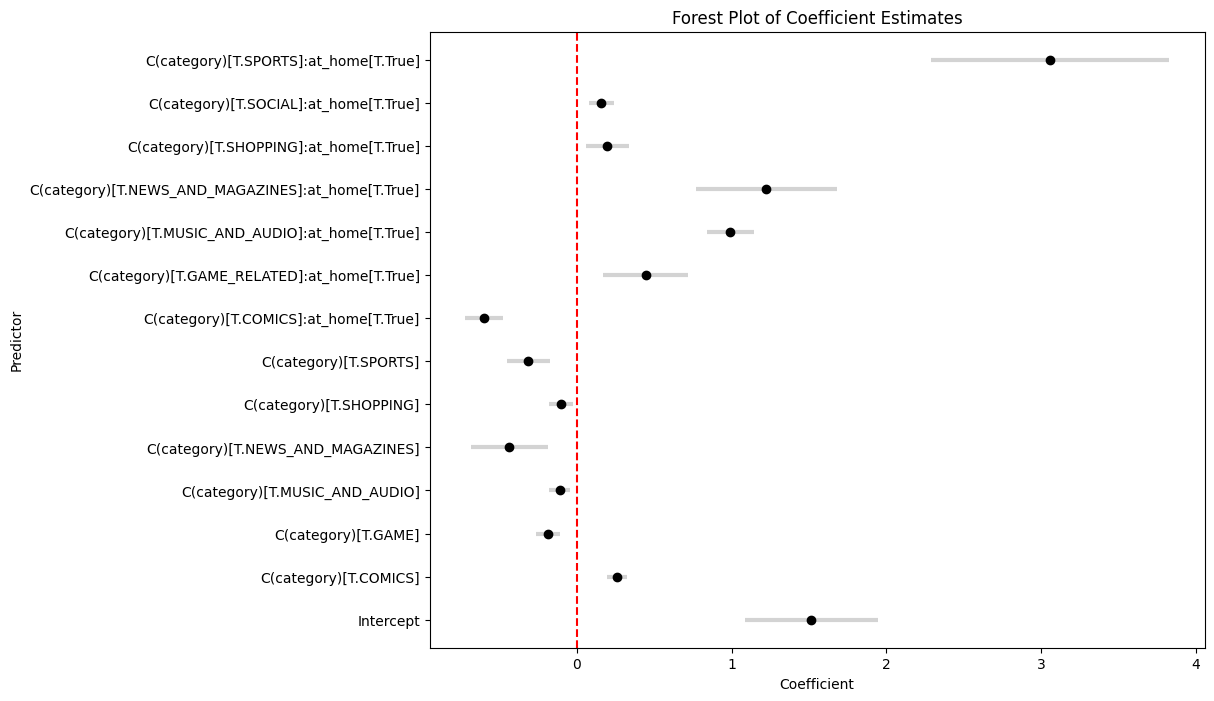

In [93]:
plot_forest(attention_results[attention_results["P>|z|"] < .05])